# IMPORTANT NOTE

## NOTE FOR MYSELF:

something is going on with TOI 1657, a QLP target that Ian claims has a TSM of 200 but I calculate to be 122. I realized that my Teq calculation differs pretty strongly from the one provided by tev.mit.edu. I have absolutely no clue why this is so but I should probably fix this trash smh


This version of the code is for me (Nicholas) to meddle with, testing fixes and generating arguments for why we should observe certain targets. This is perhaps a template for things you can do with the tutorial, but is a much messier file, so beware

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy as ap
from scipy.stats import binned_statistic_dd
from scipy.stats import linregress

# Atmospheric Prioritization

The goal of this code is to find planets which are good candidates for atmospheric follow-up. We are particularly interested in planets which are from poorly-covered regions of parameter space (e.g., smaller than previously-known planets, or around different types of star, or with more/less irradiation). Because the code was developed for TESS planets, we impose a cutoff at 11.2 R_e. If you change that, beware of the breakdown of the empirical mass-radius relationship for larger planets; you will need to implement a statistical model, e.g. mr_forecaster by Chen & Kipping 2017. 

In [2]:
from priority_tools import *

# Loading the Necessary Data

The first thing to do is get all the data set up. You need to load in the toi+ list (data/toi/toi+-...), where ... is the date of the most recent data release. If you are curious about previous releases, some of them are also in that directory. You also need the TIC star info, which has V, J, and K magnitudes that are missing from TOI+. 

In [3]:
#generate the key names for all the TOI+ columns we need
rp_key,ms_key,pp_key,Ts_key,ars_key,Jmag_key,\
    Vmag_key,rs_key,dec_key,Fp_key,mp_key,\
    mp_units,id_key = tess_colnames()

#where are the files?
toiplus_loc = 'data/toi/toi+-2020-02-28.csv'
TICinfo_loc = 'data/exofop/TIC_star_info_2020-02-28.csv'

#load the TOI+ list
toiplus = pd.read_csv(toiplus_loc,
                      delimiter=',',header=4)

#changing parameters for 
#421.01, which did not update with 
#the Gaia parameters in the TOI+ list
toi421ix = toiplus[toiplus[id_key]==421.01].index[0]
toiplus.at[toi421ix,rs_key] = 0.860124
toiplus.at[toi421ix,rp_key] = 5.32
toiplus.at[toi421ix,'Surface Gravity Value'] = 4.53273  
toiplus.at[toi421ix,Ts_key] = 5320

#changing 509 to have the correct period
toi509ix = toiplus[toiplus[id_key]==509.01].index[0]
toiplus.at[toi509ix,pp_key] = toiplus.at[toi509ix,pp_key]/2
toiplus.at[toi509ix,Fp_key] = toiplus.at[toi509ix,Fp_key]*(0.5**(-2/3))

#adding 509.02 aka 63935c
toi50902 = toiplus[toiplus[id_key]==509.01]
toi50902[id_key] = 509.02
toi50902[pp_key] = 21.28
toi50902[rp_key] = 2.48
toi50902[Fp_key] = toiplus.at[toi509ix,Fp_key] * ((9.06/21.28)**(2/3))
toi50902[mp_key] = 21.2
toiplus = toiplus.append(toi50902,ignore_index=True)

#a goes as p^2/3, F goes as 1/a^2, so F goes as p^-2/3

#load the TIC star info
TIC_info = pd.read_csv(TICinfo_loc,
                       delimiter=',',header=10)

#run the data cleaning function 
tess = clean_tess_data(toiplus, TIC_info, dec_cut=-25,
                       k_amp_cut=1.5, include_qlp=False)

#load the known planets (and Kepler PCs) table, and merge it
kps = pd.read_csv(r'data/kp-k14_pc-v14.csv')
d = tess.append(kps[np.logical_and(kps['K_amp'] > 2, 
                                   kps['TSM'] > 10)],sort=False) 
    #the K_amp cut wasn't made in the data itself, but is 
    #necessary to cut some of those not-real long-period
    #KOIs as well as known planets for which we can't get massstares
    
    #The TSM cut is also made to exclude dubious Kepler planets 
    #(i.e., way too low Rp/Rs on a dim star for atmospheres, or
    #orbiting way too far away from their host)

#give HAT-P-11 a Vmag, which is missing from exoarch for some reason
hatp11ix = d[d[id_key]=='HAT-P-11 b'].index[0]
d.at[hatp11ix,Vmag_key] = 9.47

/home/nicholas/science/atmos-env/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nicholas/science/atmos-env/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nicholas/science/atmos-env/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

# Binning

With all the data loaded, we can run the binning function and generate the pandas dataframe object that we can use for the rest of the analysis. 

In [4]:
#defining the bins: log-uniform in radius and Fp, 
#uniform in Teff. Right now, you need 6 bin edges
#for radius and Fp and 4 for Teff; we can change
#that by editing the "labels" in binning_function
rad_bins = 10**(np.linspace(0,1,6)) 
#rad_bins[0] = 0.7 #to catch any small planets a search from 1 Rp might have missed
rad_bins[-1] = 11.2
fpl_bins = 10**(np.linspace(-1,4,6))
tef_bins = np.array([2500,3900,5200,6500])
bins = [rad_bins, fpl_bins, tef_bins]

b = binning_function(d, bins) #b stands for "binned", 
                            #to make use easier

# Playing With The Data

Now, we can start looking at the data! Two very simple things we might want to do are look at a single TOI, and look at it in the context of its bin. If you've used pandas before, messing around with these data will be straightforward; if not, here are some useful tricks. To load a single object, use: b[b[id_key] == x], where x is the ID number including .01 or .02 (or .03, or whichever planet you want if it's a highly multiple system)

In [5]:
#make sure we can see the columns in the middle of the output
pd.options.display.max_columns = 100 

#call the request
b[b[id_key] == 652.01]

#the output tells us the radius, insolation, and Teff bins, as
#well as all the data from the TOI plus list and values that
#we've calculated

,,,Alerted,Centroid Offset,Effective Stellar Flux Value,Effective Temperature Uncertainty,Effective Temperature Value,Full TOI ID,Orbital Epoch Error,Orbital Epoch Value,Orbital Period Error,Orbital Period Value,Planet Equilibrium Temperature (K) Value,Planet Radius Error,Planet Radius Value,Public Comment,Sectors,Signal ID,Signal-to-noise,Source Pipeline,Star Radius Error,Star Radius Value,Surface Gravity Uncertainty,Surface Gravity Value,TIC,TIC Declination,TIC Right Ascension,TMag Uncertainty,TMag Value,Transit Depth Error,Transit Depth Value,Transit Duration Error,Transit Duration Value,Updated,pl_masses,Stellar Mass,Ars,K_amp,mass_flag,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,4,3,2019-05-07 15:39:33+0000,False,449.227034,0.0,5903.0,652.01,0.002001,1543.254774,0.000512,3.984627,1174.184168,1.354847,2.046621,small PC in known system (HD 86226 b has P = 1...,9,1.0,16.159866,spoc,0.0,1.02,0.0,4.44653,22221375.0,-24.099333,149.124333,0.017,7.358,23.16654,389.73384,0.347213,2.398698,2019-05-07 15:39:33+0000,4.85197,1.060128,10.576456,1.885677,0.0,22221375.0,149.123515,-24.099186,7.93,6.839,6.577,6.463,117.747614,NaN,2,4,3,3.0


In [22]:
#you can also ask for a few specific columns if you want 
#a much less messy output; we'll call these uks for 
#"useful keys" for the future 

uks = [id_key,rp_key,pp_key,Ts_key,Fp_key,'TSM','V mag','J mag','priority']
b[b[id_key] == 'K2-18 b'][uks]

,,,Full TOI ID,Planet Radius Value,Orbital Period Value,Effective Temperature Value,Effective Stellar Flux Value,TSM,V mag,J mag,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,
2,2,1,K2-18 b,2.37,32.939623,3457.0,1.050929,35.203684,13.496,9.763,0.0


In [23]:
#look into this bin, and select only the top 5 (by TSM)
b.loc[2,2,1][uks]

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                      
2          2         1                  736.01             2.019085   
                     1             LP 791-18 c             2.310000   
                     1                 1276.01             2.337752   
                     1               TOI 270 c             2.420000   
                     1                  732.02             1.785398   
                     1                G 9-40 b             2.025000   
                     1               TOI 270 d             2.130000   
                     1                 1468.01             2.333273   
                     1                 1266.01             2.411583   
                     1                 1452.01             1.830797   
                     1                  782.01             2.003358   
                     1                 1743.01             1.603593   
                     1            Kepler-445 c             2.510000   
                     1                 1633.01             1.916028   
                     1                 K2-18 b             2.370000   
                     1                 1754.01             2.400014   
                     1                K2-133 d             2.003000   
                     1                  K2-9 b             2.250000   
                     1            Kepler-568 b             2.260000   
                     1                K2-251 b             2.350000   
                     1                K2-150 b             2.000000   
                     1            Kepler-732 b             2.180000   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
2          2         1                        4.990070   
                     1                        4.989963   
                     1                        6.264298   
                     1                        5.660172   
                     1                       12.254218   
                     1                        5.746007   
                     1                       11.380140   
                     1                       15.531925   
                     1                       10.895412   
                     1                       11.064093   
                     1                       16.047204   
                     1                        4.265874   
                     1                        4.871229   
                     1                       12.158280   
                     1                       32.939623   
                     1                       16.217297   
                     1                       11.024540   
                     1                       18.449800   
                     1                       11.023475   
                     1                        9.300750   
                     1                       10.593570   
                     1                        9.467814   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
2          2         1                                 2940.0   
                     1                                 2960.0   
                     1                                 3145.0   
                     1                                 3386.0   
                     1                                 3329.0   
                     1                                 3348.0   
                     1                                 3386.0   
                     1                                 3382.0   
                     1                                 3618.0   
                     1                                 3248.0   
                     1                                 3331.0   
                     1                                 3281.0   
                     1     

# The Visualization Tool
Let's try the visualization tool, which displays all the high-priority objects in a given radius bin. Priority 1 is green, 2 is yellow, 3 is orange. Additionally, any planets with known transmission spectra are displayed in red (for those with observed features) or grey (for those with no observed features; note that, especially for confirmed TESS planets, observations might be very limited so "no observed features" doesn't necessarily mean cloudy). 

Dots scale linearly with planet radius. Labels indicate the object: floats are TOIs (i.e. "421.01" is TOI 421.01), anything starting with "K0" or "EPIC" is an unconfirmed KOI or K2 object, respectively, and everything else is a confirmed planet (including some previously-confirmed TOIs - for example TOI 270c falls into this category). Note that long-period KOIs (i.e., those in the top left - with relatively hot stars but earth-like insolation) are generally considered unreliable and should not automatically be assumed to actually exist or be good potential atmospheric targets. 

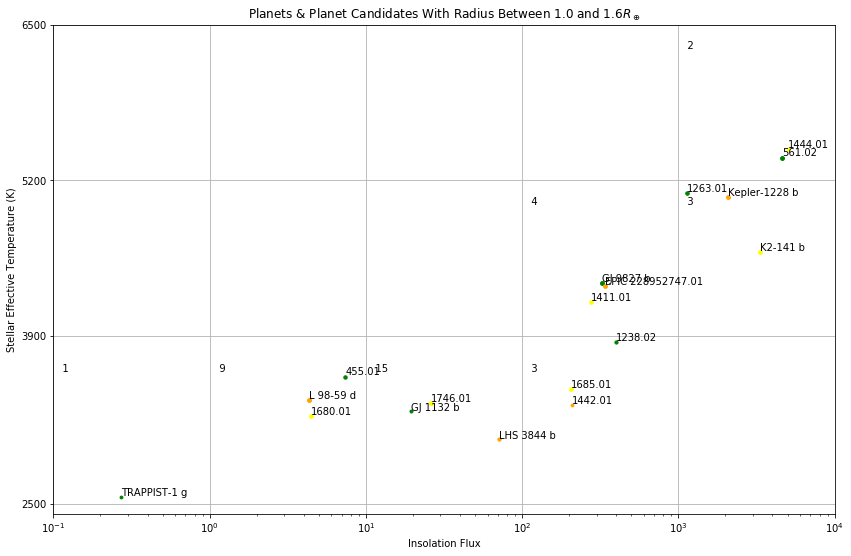

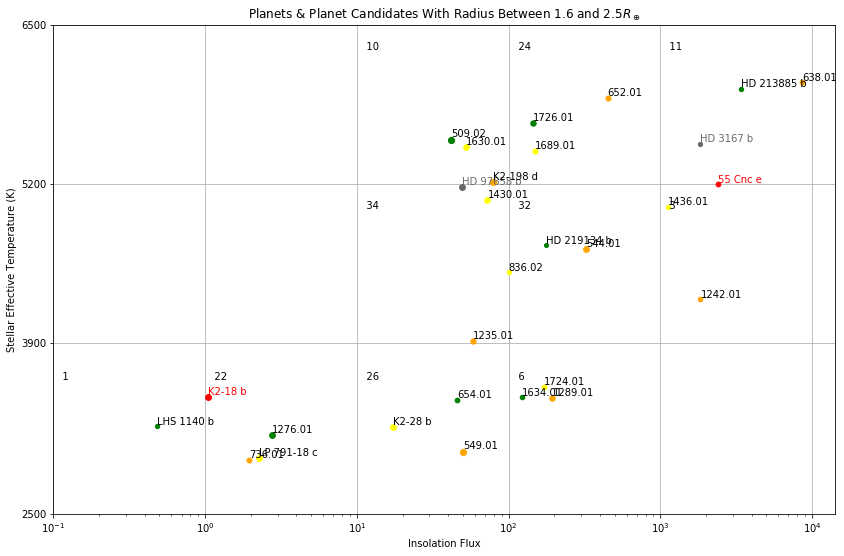

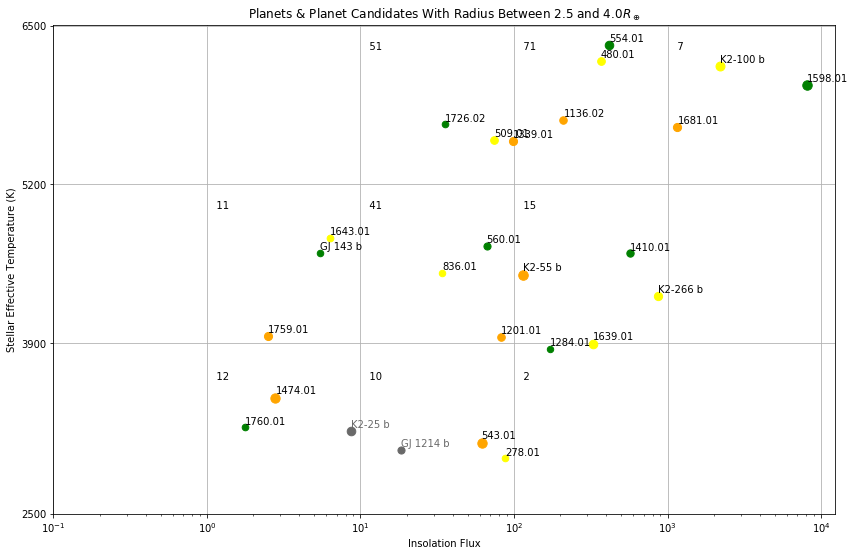

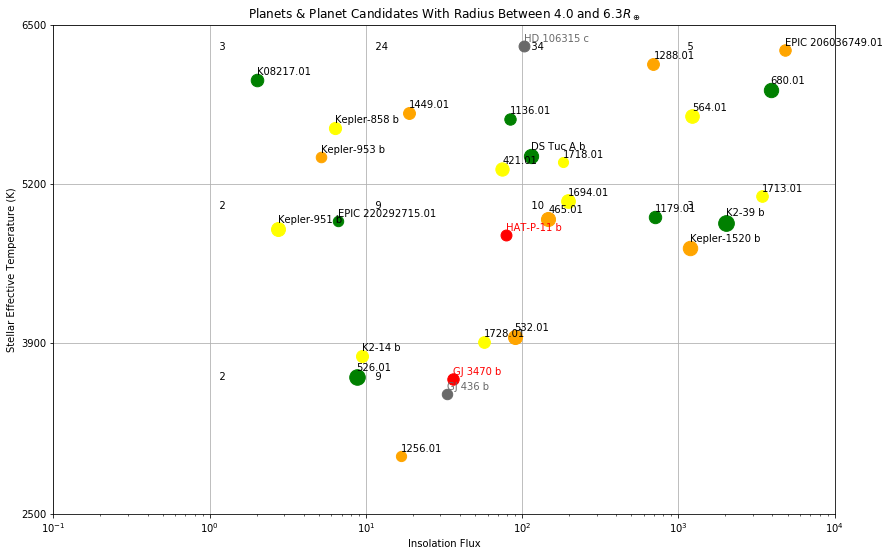

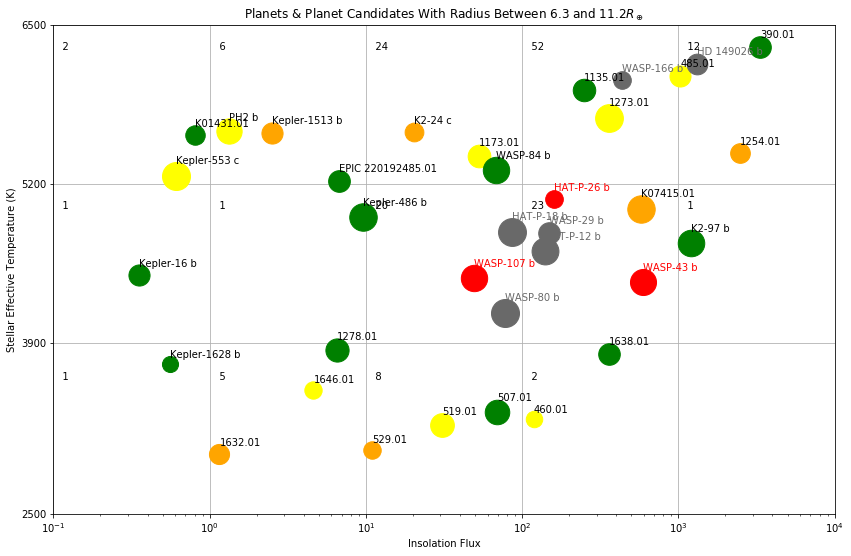

In [24]:
#bin_plotter inputs are the binned data, the bin edges
#(as defined above), and the radius bin of interest
for i in np.arange(1,6):
    bin_plotter(b,bins,i)

# Getting TOIs Only

If we only want to look at the high priority TOIs, excluding known planets and Kepler PCs, we can exploit that the TOIs in the list are uniquely identified by floats instead of strings, and can make btois (binned, tois) a new DataFrame that only contains them. We can then do convenient stuff like select only a certain range of TOI numbers (which we can't do with the regular b because Python throws an error when you put a string and float into the operator '>' or '<'. 

In [25]:
vtype = np.vectorize(type)
btois = b[vtype(b[id_key])==float]
btois[np.logical_and.reduce((btois[id_key] > 1700,btois['priority']!=0,
                             btois[Vmag_key]<12.5))][uks]#,btois['Source Pipeline']=='spoc',
                            #btois[id_key]!=1718.01))][uks].sort_values(by=id_key)

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                    
2          4         3               1726.01             2.158585   
3          2         2               1759.01             3.234794   
           3         3               1726.02             2.635970   
4          3         2               1728.01             4.699432   
           4         3               1718.01             4.042342   
           5         2               1713.01             4.653690   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
2          4         3                        7.108153   
3          2         2                       37.696127   
           3         3                       20.545913   
4          3         2                        3.491567   
           4         3                        5.586947   
           5         2                        0.557201   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
2          4         3                                5694.11   
3          2         2                                3960.00   
           3         3                                5694.11   
4          3         2                                3907.00   
           4         3                                5378.00   
           5         2                                5097.60   

                                  Effective Stellar Flux Value         TSM  \
radius_bin insol_bin st_Teff_bin                                             
2          4         3                              145.564668  212.598959   
3          2         2                                2.486239   64.300492   
           3         3                               35.353393  193.511870   
4          3         2                               57.019625  134.915225   
           4         3                              182.580139  174.407928   
           5         2                             3415.825831  156.077598   

                                     V mag  J mag  priority  
radius_bin insol_bin st_Teff_bin                             
2          4         3             6.92035  5.624       1.0  
3          2         2            11.93000  8.771       3.0  
           3         3             6.92035  5.624       1.0  
4          3         2            12.39000  9.642       2.0  
           4         3             8.96000  7.579       2.0  
           5         2            11.43600  9.775       2.0

In [26]:
#this also allows us to round stuff, to see everything from a particular system at once!
btois[np.round(btois[id_key].astype(float))==509][uks]

,,,Full TOI ID,Planet Radius Value,Orbital Period Value,Effective Temperature Value,Effective Stellar Flux Value,TSM,V mag,J mag,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,
2,3,3,509.02,2.480000,21.280000,5560.26,42.061493,68.863374,8.58,7.304,1.0
3,3,3,509.01,3.073257,9.059905,5560.26,74.321358,122.895245,8.58,7.304,2.0


In [27]:
b.loc[3,3,3][uks]

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                           
3          3         3                      1726.02             2.635970   
                     3                      1339.01             3.247601   
                     3                       509.01             3.073257   
                     3                       469.01             3.685246   
                     3                       561.01             3.772776   
                     3                      1339.02             3.067978   
                     3                      1247.01             2.800653   
                     3                      1691.01             3.746702   
                     3                      1723.01             3.156970   
                     3                       561.03             2.842121   
                     3                      1279.01             2.726668   
                     3                      1277.02             3.549235   
                     3                    TOI 125 c             2.790000   
                     3                       254.01             3.283981   
                     3                      1464.01             3.304004   
                     3                      1762.01             3.921671   
                     3                      1249.01             3.264862   
                     3                      1451.01             2.724850   
                     3                     K2-178 b             3.558000   
                     3                       518.01             3.618524   
                     3                    KOI-142 b             3.780000   
                     3                     K2-138 e             3.290000   
                     3                  Kepler-96 b             2.670000   
                     3                      K2-53 b             2.600000   
                     3                      1441.01             2.780422   
                     3                     K2-201 c             3.286000   
                     3                     K2-158 b             2.640000   
                     3                     K2-138 f             2.810000   
                     3                      K2-37 d             2.730000   
                     3            EPIC 212204403.02             2.600000   
                     3            EPIC 201352100.01             2.873000   
                     3             EPIC 220674823 c             2.730000   
                     3                     K2-172 c             3.206000   
                     3                     K2-193 b             3.950000   
                     3                     K2-195 b             3.130000   
                     3                      K2-70 b             2.890000   
                     3                     K2-183 c             2.870000   
                     3                    K00103.01             2.620000   
                     3                  Kepler-20 c             3.047000   
                     3            EPIC 220294712.01             3.119000   
                     3                Kepler-1642 b             3.200000   
                     3                    K00308.01             3.720000   
                     3                     K2-183 d             2.860000   
                     3                      K2-10 b             3.840000   
                     3                     K2-207 b             2.606000   
                     3                     K2-272 b             2.910000   
                     3                  HD 119130 b             2.630000   
                     3                 Kepler-478 b             2.710000   
                     3            EPIC 211978988.01             2.968000   
                     3            EPIC 220648214.01             2.917000   
                     3                 Kepler-949 b             2.910000   

           

In [28]:
b.loc[2,4,2][uks]

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                           
2          4         2                  HD 219134 b             1.602000   
                     2                       544.01             2.322642   
                     2                       836.02             1.813131   
                     2                      1416.01             1.659544   
                     2                      1683.01             2.390933   
                     2                      1260.01             2.401090   
                     2                       238.01             1.676542   
                     2                      1466.01             2.491658   
                     2            EPIC 229133720.01             2.338000   
                     2                      1346.02             1.979445   
                     2                      1757.01             2.079570   
                     2                      1748.01             1.667805   
                     2                       494.01             2.329152   
                     2                       556.01             1.956110   
                     2                     K2-275 b             2.240000   
                     2                     K2-199 b             1.870000   
                     2                      1446.01             2.224311   
                     2                   HD 15337 b             1.640000   
                     2            EPIC 211533633.01             1.700000   
                     2                 Kepler-475 b             2.490000   
                     2                 Kepler-994 b             1.600000   
                     2            EPIC 211552050.01             1.900000   
                     2                     K2-247 b             2.120000   
                     2                 Kepler-960 b             2.290000   
                     2                 Kepler-845 b             2.040000   
                     2                     K2-216 b             1.750000   
                     2                 Kepler-755 b             1.760000   
                     2                     K2-250 b             2.440000   
                     2                 Kepler-621 b             2.300000   
                     2                 Kepler-968 b             2.000000   
                     2                 Kepler-674 b             1.690000   
                     2                 Kepler-658 b             1.630000   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
2          4         2                        3.092926   
                     2                        1.548214   
                     2                        3.817115   
                     2                        1.069690   
                     2                        3.057601   
                     2                        3.127160   
                     2                        1.272419   
                     2                        1.871529   
                     2                        4.036791   
                     2                        1.762233   
                     2                        2.125617   
                     2                        1.831811   
                     2                        1.701876   
                     2                        2.294185   
                     2                        3.280961   
                     2                        3.225338   
                     2                        6.317190   
                     2                        4.756150   
                     2                        2.126953   
                     2                        3.105508   
                     2                        1.151167   
                     2                        3.544965   
                     2                        2.250210   
     

In [29]:
b[b[id_key]=='HD 97658 b'][uks]

,,,Full TOI ID,Planet Radius Value,Orbital Period Value,Effective Temperature Value,Effective Stellar Flux Value,TSM,V mag,J mag,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,
2,3,2,HD 97658 b,2.354,9.4909,5175.0,49.408648,133.651193,7.71,6.203,1.0


In [32]:
b[b[id_key]=='GJ 1132 b']

,,,Alerted,Centroid Offset,Effective Stellar Flux Value,Effective Temperature Uncertainty,Effective Temperature Value,Full TOI ID,Orbital Epoch Error,Orbital Epoch Value,Orbital Period Error,Orbital Period Value,Planet Equilibrium Temperature (K) Value,Planet Radius Error,Planet Radius Value,Public Comment,Sectors,Signal ID,Signal-to-noise,Source Pipeline,Star Radius Error,Star Radius Value,Surface Gravity Uncertainty,Surface Gravity Value,TIC,TIC Declination,TIC Right Ascension,TMag Uncertainty,TMag Value,Transit Depth Error,Transit Depth Value,Transit Duration Error,Transit Duration Value,Updated,pl_masses,Stellar Mass,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,1,NaN,NaN,19.302445,NaN,3270.0,GJ 1132 b,NaN,NaN,NaN,1.628931,NaN,NaN,1.2,NaN,NaN,NaN,NaN,NaN,NaN,0.21,NaN,NaN,NaN,-47.156727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.66,0.18,15.668803,2.834932,NaN,NaN,NaN,13.49,9.245,NaN,NaN,37.45,88.0,1,3,1,1.0


In [31]:
get_TSM?
get_TSM(np.array([1.2]), 0.21, 3270, 9.245, 1.6, 16.54)

array([37.45447977])

In [15]:
b[b[Fp_key]<1.5]

Alerted Centroid Offset  \
radius_bin insol_bin st_Teff_bin                                             
1          1         1                                 NaN             NaN   
           2         1            2018-11-30 22:06:23+0000             NaN   
2          1         1                                 NaN             NaN   
           2         1            2019-06-11 20:03:40+0000           False   
                     1                                 NaN             NaN   
                     1                                 NaN             NaN   
5          1         1                                 NaN             NaN   
                     2                                 NaN             NaN   
                     3                                 NaN             NaN   
                     3                                 NaN             NaN   
           2         1            2020-01-14 19:46:38+0000             NaN   
                     3                                 NaN             NaN   

                                  Effective Stellar Flux Value  \
radius_bin insol_bin st_Teff_bin                                 
1          1         1                                0.272432   
           2         1                                1.226056   
2          1         1                                0.480206   
           2         1                                1.455555   
                     1                                1.050929   
                     1                                1.358794   
5          1         1                                0.559174   
                     2                                0.354695   
                     3                                0.800000   
                     3                                0.606758   
           2         1                                1.155260   
                     3                                1.320072   

                                  Effective Temperature Uncertainty  \
radius_bin insol_bin st_Teff_bin                                      
1          1         1                                          NaN   
           2         1                                          0.0   
2          1         1                                          NaN   
           2         1                                         63.0   
                     1                                          NaN   
                     1                                          NaN   
5          1         1                                          NaN   
                     2                                          NaN   
                     3                                          NaN   
                     3                                          NaN   
           2         1                                        158.0   
                     3                                          NaN   

                                  Effective Temperature Value    Full TOI ID  \
radius_bin insol_bin st_Teff_bin                                               
1          1         1                                 2559.0   TRAPPIST-1 g   
           2         1                                 3131.0         256.01   
2          1         1                                 3216.0     LHS 1140 b   
           2         1                                 3331.0         782.01   
                     1                                 3457.0        K2-18 b   
                     1                                 3390.0         K2-9 b   
5          1         1                                 3724.0  Kepler-1628 b   
                     2                                 4450.0    Kepler-16 b   
                     3                                 5597.0      K01431.01   
                     3                                 5266.0   Kepler-553 c   
           2         1                                 2990.0        1632.01  

In [17]:
b.loc[5,4,3][uks].sort_values('TSM', ascending=False)

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                             
5          4         3                     WASP-166 b             7.062000   
                     3                        1135.01             9.001699   
                     3                        1273.01            11.109674   
                     3                        1194.01             8.860766   
                     3                     WASP-139 b             8.967000   
                     3                         576.01             7.242169   
                     3                        1251.01             9.891187   
                     3              EPIC 218170789.01             8.989000   
                     3                       HATS-5 b            10.223000   
                     3                        1248.01             7.205111   
                     3                     WASP-157 b            11.190000   
                     3                     WASP-182 b             9.528000   
                     3              EPIC 219388192.01             9.978000   
                     3                     HD 89345 b             7.398000   
                     3                         239.01             6.374038   
                     3                      HATS-46 b            10.122000   
                     3                         660.01            11.115877   
                     3                     HAT-P-38 b             9.247000   
                     3                      WASP-56 b            10.536000   
                     3              EPIC 205703094.02            11.000000   
                     3                       K2-261 b             9.528000   
                     3                       HATS-8 b             9.785000   
                     3                   Kepler-491 b             8.920000   
                     3                      HATS-10 b            10.862000   
                     3                     WASP-129 b            10.424000   
                     3                      WASP-60 b             9.864000   
                     3                    Kepler-77 b            10.761000   
                     3                       K2-271 b             7.280000   
                     3            CoRoTID 223977153 b             6.389000   
                     3                   Kepler-720 b             8.410000   
                     3                       K2-308 b             9.916000   
                     3                   Kepler-628 b             8.400000   
                     3                   Kepler-688 b             9.760000   
                     3              EPIC 202675839.01             9.200000   
                     3                        1267.01             9.250935   
                     3                        K2-87 b             7.600000   
                     3                   Kepler-546 b             7.000000   
                     3                    Kepler-15 b            10.760000   
                     3                      WASP-32 b            10.761000   
                     3                   Kepler-817 b             9.030000   
                     3                        K2-60 b             7.656000   
                     3                   Kepler-855 b             8.350000   
                     3                   Kepler-856 b             9.300000   
                     3              EPIC 212639319.01             6.761000   
                     3                   Kepler-673 b             6.540000   
                     3                   Kepler-494 b             7.140000   
                     3                   Kepler-714 b             9.670000   
                     3                   Kepler-703 b             8.200000   
                     3                   Kepler-117 b             8.059000   
                     3                    Kepler-74 b           

In [15]:
#old_tois = old_tois[old_tois['priority']!=0]
#new_tois = btois[btois['priority']!=0]
#
#for ntoi in np.array(new_tois[id_key]):
#    if ntoi not in np.array(old_tois[id_key]):
#        print(str(ntoi) + ' is a new priority target')
#        continue
#    #if new_tois[new_tois[id_key]==ntoi]['priority'].values != old_tois[old_tois[id_key]==ntoi]['priority'].values:
#    #    print(str(ntoi) + ' changed from priority ' + str(old_tois[old_tois[id_key]==ntoi]['priority'].values) + 
#    #         'to priority ' + str(new_tois[new_tois[id_key]==ntoi]['priority'].values))

In [16]:
#old_tois[old_tois[id_key]==1702.01]

In [17]:
#for otoi in np.array(old_tois[id_key]):
#    if otoi not in np.array(new_tois[id_key]):
#        print(str(otoi) + ' was removed by the latest update')
#        continue

In [25]:
#btois[np.logical_and.reduce((btois['TSM']>100,btois[Vmag_key]>12,btois[Jmag_key]<11))][uks]
btois[np.logical_and(btois['TSM'] > 200,btois[rp_key] < 4)][uks]

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                    
2          3         1                549.01             2.442348   
           4         3               1726.01             2.158585   
3          3         1                278.01             2.630575   
                     1                457.01             2.805385   
                     1                543.01             3.747202   
                     2                431.01             3.867820   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
2          3         1                        0.516278   
           4         3                        7.108153   
3          3         1                        0.298746   
                     1                        1.176044   
                     1                        0.530893   
                     2                       12.459410   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
2          3         1                                3009.00   
           4         3                                5694.11   
3          3         1                                2955.00   
                     1                                3054.00   
                     1                                3085.00   
                     2                                4771.00   

                                  Effective Stellar Flux Value         TSM  \
radius_bin insol_bin st_Teff_bin                                             
2          3         1                               50.416636  237.852133   
           4         3                              145.564668  212.598959   
3          3         1                               87.896848  647.597123   
                     1                               19.413774  248.108913   
                     1                               61.427191  220.252907   
                     2                               50.187300  202.362915   

                                     V mag   J mag  priority  
radius_bin insol_bin st_Teff_bin                              
2          3         1            17.60000  12.431       3.0  
           4         3             6.92035   5.624       3.0  
3          3         1            16.45000  11.171       2.0  
                     1            17.04000  11.901       3.0  
                     1            18.17000  13.371       0.0  
                     2             9.12000   7.305       1.0

In [14]:
b[np.logical_and(b['Source Pipeline']=='qlp',b['priority']==1)][uks]

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                    
1          5         3                895.01              1.54691   
2          5         3                440.01              2.07554   
3          4         2               1319.01              3.81320   
           5         1                716.01              2.98849   
                     2               1702.01              2.95177   
4          3         3               1710.01              5.40603   
           5         2                980.01              4.57689   
5          3         3               1605.01             10.79290   
           4         3               1456.01              8.32898   
           5         2                950.01              8.05346   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
1          5         3                         0.76189   
2          5         3                         1.08170   
3          4         2                         1.78411   
           5         1                         0.83707   
                     2                         0.40312   
4          3         3                        24.28313   
           5         2                         1.33476   
5          3         3                         8.70012   
           4         3                        12.15601   
           5         2                         1.14288   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
1          5         3                                 5928.5   
2          5         3                                 5759.2   
3          4         2                                 5159.2   
           5         1                                 3776.0   
                     2                                 4252.9   
4          3         3                                 5675.0   
           5         2                                 5196.0   
5          3         3                                 5546.3   
           4         3                                 6042.5   
           5         2                                 5125.8   

                                  Effective Stellar Flux Value         TSM  \
radius_bin insol_bin st_Teff_bin                                             
1          5         3                             6156.940000   60.331152   
2          5         3                             2462.700975  161.341179   
3          4         2                              505.432000  176.842980   
           5         1                             2645.930000   88.148296   
                     2                             1215.980000   96.498513   
4          3         3                               35.709700  108.276533   
           5         2                             2632.760000   37.219981   
5          3         3                               60.899400  171.783847   
           4         3                              204.801000  231.864439   
           5         2                             1059.750000  102.026361   

                                      V mag      J mag  priority  
radius_bin insol_bin st_Teff_bin                                  
1          5         3             9.349000   8.262000       1.0  
2          5         3             8.270001   7.082000       1.0  
3          4         2            10.104000   8.579001       1.0  
           5         1            14.128000  11.184000       1.0  
                     2            12.075000   9.892000       1.0  
4          3         3             9.545000   8.319000       1.0  
           5         2            10.926000   9.602000       1.0  
5          3         3            10.197000   8.900000       1.0  
           4         3             8.558000   7.509000       1.0  
           5         2            11.117000   9.4500

# NOTE TO NICHOLAS (SELF): ADD TOI 260.01 TO THIS LIST; IT HAS A TON OF MASS MEASUREMENTS FROM TKS

Also 266 oh wait nvm it's not an atmospheric target

Text(0.5, 1.0, 'Planets from 1-11.2 $R_\\oplus$ with TKS Masses, Compared to Planets With Known Spectra')

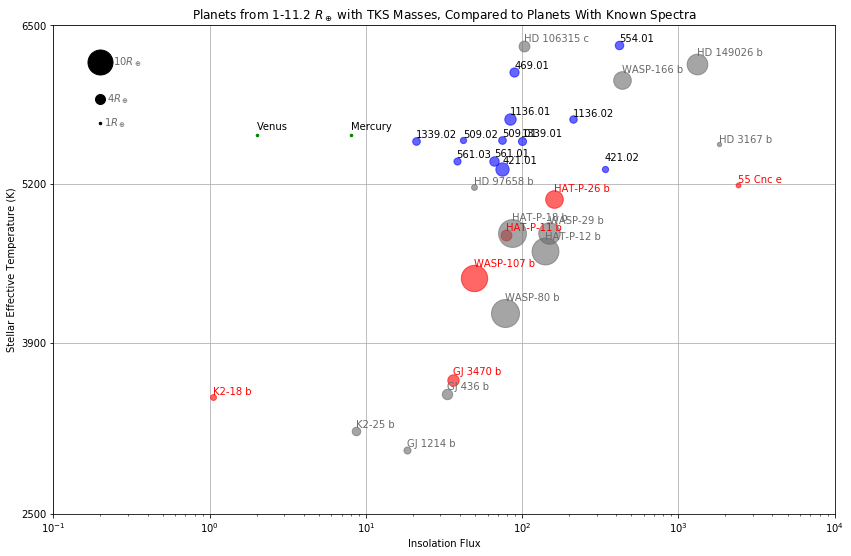

In [72]:
kpwks, hf = return_known_spectra()
#data_copy = b.copy()
b['has_spectrum'] = has_obs(b, kpwks)

rbin1=b[np.logical_or(
    np.logical_or.reduce((
        b[id_key] == 561.01, b[id_key] == 554.01, 
        b[id_key] == 421.01, b[id_key] == 469.01, 
        b[id_key] == 509.01, b[id_key] == 'GJ 357 b', 
        b[id_key] == 431.01, b[id_key] == 1136.01, 
        b[id_key] == 1136.02,b[id_key] == 431.01, 
        b[id_key] == 442.01, b[id_key] == 561.03, 
        b[id_key] == 431.02, b[id_key] == 509.02, 
        b[id_key] == 1339.02, b[id_key] == 1339.01, 
        b[id_key] == 1339.03
        )), 
    b['has_spectrum']==1
    )
       ]
F = np.array(rbin1[Fp_key])
Ts = np.array(rbin1[Ts_key])
rp = np.array(rbin1[rp_key])
P = np.array(rbin1['priority'])
N = np.array(rbin1[id_key])


def colorfinder(name, priority):
    if name in kpwks:
        idx = kpwks.index(name)
        if hf[idx]:
            return 'red'
        elif not hf[idx]:
            return 'dimgrey'
    else:
        return 'blue'
def textcolorfinder(name):
    if name in kpwks:
        idx = kpwks.index(name)
        if hf[idx]:
            return 'red'
        elif not hf[idx]:
            return 'dimgrey'
    else:
        return 'black'

fig, ax = plt.subplots(figsize=(14,9))
ax.grid()
txt = np.array(rbin1[id_key])

#doing the title stuff
bin_edges = np.round(bins[0],1)
title_txt = r'Planets from 1-11.2 $R_\oplus$ with TKS Masses, Compared to Planets With Known Spectra'


for i in np.arange(len(rbin1)):
    ax.semilogx(F[i], Ts[i], '.',ms=rp[i]*5,color=colorfinder(N[i],P[i]),alpha=0.6)
    ax.annotate(txt[i], (F[i], Ts[i]+rp[i]*9),color=textcolorfinder(N[i]))

ax.semilogx(337.1449, 5320, '.',ms=2.5*5,color='blue',alpha=0.6)
ax.annotate('421.02', (337.1449, 5320+rp[i]*9),color='black')

#mercury
ax.semilogx(8, 5600, '.', ms=5, color='green')
ax.annotate('Mercury', (8, 5600+45),color='black')

#venus
ax.semilogx(2, 5600, '.', ms=5, color='green')
ax.annotate('Venus', (2, 5600+45),color='black')

height = 5700
    #earth dot size
ax.semilogx(2e-1, height, '.', ms=5, color='black')
ax.annotate(r'$1 R_\oplus$', (2e-1+1e-2, height-25),color=textcolorfinder(N[i]))

    #neptune dot size
ax.semilogx(2e-1, height+200, '.', ms=20, color='black')
ax.annotate(r'$4 R_\oplus$', (2e-1+2e-2, height+200-25),color=textcolorfinder(N[i]))

    #sligthly sub-Jovian dot size
ax.semilogx(2e-1, height+500, '.', ms=50, color='black')
ax.annotate(r'$10 R_\oplus$', (2e-1+4e-2, height+500-25),color=textcolorfinder(N[i]))
    
##added for TKS in person
#for f in np.arange(1,6,1):
#    for t in np.arange(1,4,1):
#        try:
#            size = len(b.loc[rbin,f,t])
#            ax.annotate('   ' + str(size),(fpl_bins[f-1],tef_bins[t-1]+1100))
#        except KeyError:
#            continue
#
ax.set_yticks(tef_bins)
ax.set_xticks(fpl_bins)
ax.set_ylabel('Stellar Effective Temperature (K)')
ax.set_xlabel(r'Insolation Flux')
ax.set_title(title_txt)

In [67]:
b[b[id_key] == 1339.01]

,,,Alerted,Centroid Offset,Effective Stellar Flux Value,Effective Temperature Uncertainty,Effective Temperature Value,Full TOI ID,Orbital Epoch Error,Orbital Epoch Value,Orbital Period Error,Orbital Period Value,Planet Equilibrium Temperature (K) Value,Planet Radius Error,Planet Radius Value,Public Comment,Sectors,Signal ID,Signal-to-noise,Source Pipeline,Star Radius Error,Star Radius Value,Surface Gravity Uncertainty,Surface Gravity Value,TIC,TIC Declination,TIC Right Ascension,TMag Uncertainty,TMag Value,Transit Depth Error,Transit Depth Value,Transit Duration Error,Transit Duration Value,Updated,pl_masses,Stellar Mass,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority,has_spectrum
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,3,2019-10-30 15:08:00+0000,NaN,99.065848,313.7,5555.7,1339.01,0.00253,1715.354486,0.00082,8.880832,804.638372,0.355049,3.247601,multi-planet system; candidate .01,14 15 16 17 18 19,1.0,31.063261,spoc,0.1,0.920435,0.08,4.49,269701147.0,66.850576,302.023979,0.006,8.293,39.24843,1213.388063,0.156,3.019178,2019-10-30 15:08:00+0000,10.636799,0.954144,19.308262,3.394956,269701147.0,302.025625,66.850301,8.97,7.597,7.215,7.18,131.538519,NaN,3,3,3,3.0,0.0


In [104]:
mykps = b[np.logical_and.reduce((b['J mag'] < 14, b['TSM'] > 30,vtype(b[id_key])!=float))]
mykps.sort_values(by='TSM',ascending=False)[uks][:20]

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                           
5          3         2                   WASP-107 b               10.536   
3          3         1                    GJ 1214 b                2.847   
4          3         1                     GJ 436 b                4.170   
5          3         2                    WASP-80 b               11.198   
4          3         1                    GJ 3470 b                4.570   
                     2                   HAT-P-11 b                4.360   
2          4         2                  HD 219134 b                1.602   
5          4         2                   HAT-P-12 b               10.749   
4          4         3                   DS Tuc A b                5.700   
2          5         2                     55 Cnc e                1.910   
5          4         2                    K07415.01               10.970   
           3         2                   HAT-P-18 b               11.153   
           4         3                   WASP-166 b                7.062   
                     2                   HAT-P-26 b                7.062   
2          4         3                     pi Men c                2.042   
5          4         2                    WASP-29 b                8.631   
           3         2            EPIC 201127519.01                9.913   
1          3         2                  HD 219134 c                1.511   
5          4         3                   WASP-139 b                8.967   
                     2            EPIC 210365511.01                8.446   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
5          3         2                        5.721490   
3          3         1                        1.580405   
4          3         1                        2.643883   
5          3         2                        3.067852   
4          3         1                        3.336650   
                     2                        4.887802   
2          4         2                        3.092926   
5          4         2                        3.213060   
4          4         3                        8.138268   
2          5         2                        0.736539   
5          4         2                        1.291964   
           3         2                        5.508023   
           4         3                        5.443540   
                     2                        4.234520   
2          4         3                        6.267900   
5          4         2                        3.922730   
           3         2                        6.178369   
1          3         2                        6.764580   
5          4         3                        5.924262   
                     2                        3.951971   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
5          3         2                                 4430.0   
3          3         1                                 3026.0   
4          3         1                                 3479.0   
5          3         2                                 4143.0   
4          3         1                                 3600.0   
                     2                                 4780.0   
2          4         2                                 4699.0   
5          4         2                                 4650.0   
4          4         3                                 5428.0   
2          5         2                                 5196.0   
5          4         2                                 4995.0   
           3         2                                 4803.0   
           4         3                                 6050.0   
                     2                                 5079.0   
2          4         3                            

In [15]:
#I'm just listing these planets by TSM*. Anything in the
# command mykps.sort_values(by='TSM',ascending=False) 
#that's not in this list does not have a published transit 
#spectrum that I could find 
#*except GJ 436b, which comes at the end because ExoArch
#was missing its Teff for some reason

kp_w_spectra = ['WASP-107 b', 'GJ 1214 b', 'WASP-80 b', 
               'GJ 3470 b',   'HAT-P-11 b','HAT-P-12 b', 
               '55 Cnc e',    'HAT-P-18 b','WASP-166 b',
               'HAT-P-26 b',  'pi Men c',  'WASP-29 b', 
               'HD 149026 b', 'K2-25 b',   'HD 97658 b', 
               'HD 3167 b',   'GJ 436 b']

has_features = [1,             0,           0, 
               1,              1,           0,
               1,              0,           0,
               1,              0,           0, 
               0,              0,           0,
               0,              0]


Here, I'm going to list all the planets with known spectra. I won't list every paper, especially for cooked targets like GJ 1214 - the default will be HST. If it's not HST (WFC3) I'll note the instrument beside it.

WASP-107 b: [Spake et. al. 2018](https://arxiv.org/abs/1709.08635)

GJ 1214 b: [Berta et. al. 2012](https://arxiv.org/abs/1111.5621)

WASP-80 b: [Parviainen et. al. 2018](https://arxiv.org/abs/1709.01875) GTC

GJ 3470 b: [Ehrenreich et. al. 2014](https://arxiv.org/abs/1405.1056) note that the HST spectrum did not have positive identifications but they have appeared with other observations

HAT-P-11 b: [Fraine et. al. 2014](https://arxiv.org/abs/1409.8349)

HAT-P-12 b: [Line et. al. 2013](https://arxiv.org/abs/1310.4796)

55 Cnc e: [Tsiaras et. al. 2016](https://arxiv.org/abs/1511.08901)

HAT-P-18 b: [Kirk et. al. 2017](https://arxiv.org/abs/1611.06916) WHT

WASP-166 b: [Zak et. al. 2019](https://arxiv.org/abs/1907.07267) HARPS

HAT-P-26 b: [Wakeford et. al. 2017](https://arxiv.org/abs/1705.04354)

$\pi$ Men c: [Garcia Munoz et. al. 2020](https://arxiv.org/abs/1912.06913) HST STIS (UV) - note this is a TESS planet that was only search for Ly-$\alpha$ absorption, so could have other features

WASP-29 b: [Gibson et. al. 2013](https://arxiv.org/abs/1210.7798) Gemini South (GMOS)

HD 149026 b: [Jensen et. al. 2012](https://arxiv.org/abs/1203.4484) UV; unclear what instrument

K2-25 b: [Thao et. al. 2020](https://arxiv.org/abs/1911.05744) various instruments

HD 97658 b: [Knutson et. al. 2014](https://arxiv.org/abs/1403.4602)

HD 3167 b: [Guenther et. al. 2019](https://arxiv.org/abs/1911.09916) VLT (UVES)

GJ 436 b: [Knutson et. al. 2014](https://arxiv.org/abs/1401.3350) 

In [16]:
vectype = np.vectorize(type) #make a vectorized function of type
c = b[np.logical_and.reduce((b['V mag'] < 12, b['TSM'] > 30,vectype(b[id_key])==float))]
#c.loc[1,3,:]

priority_tois = pd.DataFrame()

for r in np.arange(1,6): #create rbins
    for f in np.arange(1,6): #create insolation flux bins
        
        try:
            x = c.loc[r,f,:].dropna(axis=0,subset=['TSM'])
            #get rid of NaN TSM values (mostly from KP or KOIs
            #with missing values). Keyerror exception is needed
            #to avoid putting empty bins in .loc, which returns
            #an error
     
        except KeyError:
            continue
        
        if len(x) == 1:
            priority_tois = priority_tois.append(x)
            #so if there's only one TOI brighter than 12 with a good
            #TSM, we include it since it's probably interesting to us
            #this might be something we revise if we want to say "hey, 
            #actually, let's just wait for better targets in later 
            #sectors," but as it stands without this we  lose our
            #only non-USP small planet which sounds like a raw deal
            
        else:
            priority_tois = priority_tois.append(x[x['priority']!=0])


In [17]:
pt = priority_tois

#drop TOIs which are either confirmed FPs or have already been dropped by
#TKS for activity reasons, since that means both that we won't be getting
#a mass on them any time soon and that we probably wouldn't be able to
#see their atmospheres clearly anyway 

'''
Which high-p TOIs are we dropping and why?

544.01  "possible FP", dropped from TKS
561.01  dropped from TKS due to flat-bottom
    transit but b > 1 based on other teams'
    fits
634.01  is confirmed false positive
635.01  is confirmed false positive
638.01  also confirmed FP (this, 634, and 635 
    are listed FP in the TKS Southern TOIs sheet)
656.01  is WASP-43 b (well-known mass)
680.01  was dropped from Southern TOIs for reasons
    unknown. Comments are "Achontos, Short period, 
    lots of follow-up.  Stellar companion at 0.78".
1144.01 is HAT-P-11b (well-known mass)
1260.01 failed spectroscopic vetting
1273.01 has high b and a brighter star
    nearby. Natalie said to check SG1/SG2 
    for more info *ask how to do this. 
1283.01 is HAT-P-17b (well-known mass)
1413.01 was cut due to high RUWE (2.5)
    Natalie also wanted to revisit this, 
    as I recall, so don't drop
1419.01 is HAT-P-3 b (well-known mass)
1423.01 was dropped due to v-shaped; OOT and
    odd-even both ~2.5sigma. b = 0.99 as well
1459.01 was dropped due to low SNR, high
    offsets + halo statistic *possibly should
    add back? On the other hand, at this point 
    I feel likewe should be LOOKING for reasons 
    to drop targets, since we're trying to cut 
    the sample down in size 
1598.01 was cut due to 4 sig distance offset but
    might be OK; Natalie said to look at FOP data
    when released; it's P1 and weirdly orbiting
    a seemingly evolved star so might be worth 
    adding. not cutting this one yet

'''
cpt = pt[np.logical_and.reduce((
                         pt[id_key] != 635.01, pt[id_key] != 1419.01, 
                         pt[id_key] != 656.01, pt[id_key] != 560.01, 
                         pt[id_key] != 544.01, pt[id_key] != 1260.01,
                         pt[id_key] != 638.01, pt[id_key] != 634.01, 
                         pt[id_key] != 1459.01,pt[id_key] != 1144.01,
                         pt[id_key] != 1423.01,pt[id_key] != 680.01,
                         pt[id_key] != 564.01,pt[id_key] != 1283.01,
                         pt[id_key] != 1273.01
                            ))]

In [18]:
cpt[cpt[id_key]==1695.01]

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority,has_spectrum
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [19]:
b[b[id_key] == 509.01]

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority,has_spectrum
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,4,3,spoc,453211454.0,509.01,117.92497,9.386054,7.905,0.018,1494.445731,0.001498,9.059905,0.002151,3.669772,0.189904,891.412821,42.6545,7,Looks like a transit signal but there is a pos...,4.438,0.0,1.0,0.996346,0.089708,3.073257,0.499603,667.154613,5560.26,43.3509,187.278088,19.772907,False,2019-03-15 15:42:21+0000,2019-03-15 15:42:21+0000,0.991855,9.684396,18.311228,2.992148,453211454.0,117.924642,9.385241,8.58,7.304,6.964,6.881,122.895245,NaN,3,4,3,3.0,0.0


In [20]:
667*(4**0.25)

943.2804461028545

In [21]:
m = ((10**4.357) * ((0.86*6.9551e10)**2) 
                         / 6.67e-8 ) / 1.99e33

#                   period  mass  radius

ars_421 = ars_from_t(5.196, 0.92, 0.86)
#(planet_radius,star_radius,star_teff,Jmag,planet_mass,ars)
get_TSM(np.array([2.502]), 0.86,       5320,     8.547, 6.82720367, ars_421)

array([75.96314904])

In [22]:
basic_mr(np.array([3.073257]))

array([9.6843959])

In [23]:
b[b[id_key]==509.01]

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority,has_spectrum
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,4,3,spoc,453211454.0,509.01,117.92497,9.386054,7.905,0.018,1494.445731,0.001498,9.059905,0.002151,3.669772,0.189904,891.412821,42.6545,7,Looks like a transit signal but there is a pos...,4.438,0.0,1.0,0.996346,0.089708,3.073257,0.499603,667.154613,5560.26,43.3509,187.278088,19.772907,False,2019-03-15 15:42:21+0000,2019-03-15 15:42:21+0000,0.991855,9.684396,18.311228,2.992148,453211454.0,117.924642,9.385241,8.58,7.304,6.964,6.881,122.895245,NaN,3,4,3,3.0,0.0


In [24]:
k = b[b[Vmag_key] < 14]
k[np.logical_and.reduce((k[id_key]!=278.01, k[id_key]!=1256.01, k[id_key]!=516.01, k[id_key]!=560.01))]\
    .loc[[2,3],:,:].sort_values(by='TSM',ascending=False).head(20)

Source Pipeline          TIC  \
radius_bin insol_bin st_Teff_bin                                
2          4         2                       NaN          NaN   
           5         2                       NaN          NaN   
           4         3                       NaN          NaN   
3          3         2                       qlp   31374837.0   
                     2                       qlp   70899085.0   
           4         2                       qlp  167098530.0   
2          4         3                       NaN          NaN   
           5         3                       qlp  143350972.0   
3          4         2                       NaN          NaN   
           3         1                      spoc  296739893.0   
                     2                       qlp  264678534.0   
2          4         2                      spoc   50618703.0   
           2         1                       NaN          NaN   
           3         2                       NaN          NaN   
3          3         3                      spoc  269701147.0   
2          5         3                       NaN          NaN   
           3         2                       NaN          NaN   
3          4         3                       NaN          NaN   
           3         2                      spoc  440887364.0   
           4         3                      spoc  453211454.0   

                                        Full TOI ID  TIC Right Ascension  \
radius_bin insol_bin st_Teff_bin                                           
2          4         2                  HD 219134 b                  NaN   
           5         2                     55 Cnc e                  NaN   
           4         3                     pi Men c                  NaN   
3          3         2                       431.01            83.269151   
                     2                       442.01            64.190000   
           4         2                      1319.01           318.626815   
2          4         3                     HR 858 b                  NaN   
           5         3                       440.01            82.246364   
3          4         2                     K2-266 b                  NaN   
           3         1                       620.01           142.173300   
                     2                      1611.01           325.186593   
2          4         2                       544.01            82.289925   
           2         1                    TOI 270 c                  NaN   
           3         2                   HD 97658 b                  NaN   
3          3         3                      1339.01           302.023979   
2          5         3                    HD 3167 b                  NaN   
           3         2                    GJ 9827 d                  NaN   
3          4         3            EPIC 212178066.01                  NaN   
           3         2                       836.01           225.080844   
           4         3                       509.01           117.924970   

                                  TIC Declination  TMag Value  \
radius_bin insol_bin st_Teff_bin                                
2          4         2                  57.168354         NaN   
           5         2                  28.330818         NaN   
           4         3                 -80.469124         NaN   
3          3         2                 -26.724584     8.11300   
                     2                 -12.084000    10.66200   
           4         2                  40.016685     9.32100   
2          4         3                 -30.814520         NaN   
           5         3                 -17.429212     7.65200   
3          4         2                   0.937571         NaN   
           3         1                 -12.165500    10.09700   
                     2                  84.333490     7.58200   
2          4         2                  -0.342560     9.57700   
           2       

In [25]:
b[b[id_key]==278.01]['Public Comment']

radius_bin  insol_bin  st_Teff_bin
3           3          1              possible dipper; not a planet candidate; Rstar...
Name: Public Comment, dtype: object

In [26]:
toiplus[toiplus[id_key]==1696.01]

,Source Pipeline,TIC,Full TOI ID,TOI Disposition,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,TFOP Master,TFOP SG1a,TFOP SG1b,TFOP SG2,TFOP SG3,TFOP SG4,TFOP SG5,Alerted,Updated
241,spoc,470381900,1696.01,PC,65.280563,48.819914,13.9664,0.007301,1816.697706,0.002752,2.500715,0.000511,0.984599,0.440975,11012.483893,1568.8007,19,centroid offset relative to oot centroid posit...,4.94798,0.008061,1,0.280475,0.008573,2.968968,1.348479,491.634409,3181.0,157.0,13.806706,7.640768,NaN,1,4,1,1,4,4,4,2020-01-30 21:16:42+0000,2020-01-25 01:12:02+0000


In [27]:
TIC_info[TIC_info['Target'] == 470381900]

,Target,RA,Dec,V mag,J mag,H mag,K mag
729,470381900,65.280648,48.819831,16.82,12.233,11.604,11.331


In [28]:
##all priorities
#p1 = b[b['priority']==1].reset_index(drop=True)[id_key].values
#p1tois = []
#for obj in p1:
#    if type(obj) == float:
#        p1tois.append(obj)
#p1tois.sort()
##p1tois

In [29]:
##all priorities
#p2 = b[b['priority']==2].reset_index(drop=True)[id_key].values
#p2tois = []
#for obj in p2:
#    if type(obj) == float:
#        p2tois.append(obj)
#p2tois.sort()
##p2tois

In [30]:
#p3 = b[b['priority']==3].reset_index(drop=True)[id_key].values
#p3tois = []
#for obj in p3:
#    if type(obj) == float:
#        p3tois.append(obj)
#p3tois.sort()
##p3tois

In [31]:
#for r in np.arange(1,6,1):
#    for f in np.arange(1,6,1):
#        for t in np.arange(1,4,1):
#            try:
#                x = b.loc[r,f,t].dropna(axis=0,subset=['TSM'])
#            except KeyError:
#                continue
#            med = np.median(x['TSM'])
#            if med == 0:
#                med = np.mean(x['TSM'])
#            x['Value'] = (x['TSM'] / med) - (x['V mag']/3)
#            print(med)
#            print(x[x['Value']>0][[id_key,'Value']])
#'''
#ok, so,this works ok, but we need more:
#    -how to relatively deprioritize something if a bunch of other ones
#        are equally valuable. That is, even if it's above the median, 
#        as long as we have ONE that we get a good mass one, we're not
#        as interested (e.g. the 333 bin, which is quite populous)
#    -make sure we cut above V 12 or 13; generally ensure that 
#        the ones we're picking are actually observable 
#'''           
# decided not to do this; natalie just wants us to prioritize bins 

Text(0.5, 1.0, 'Period-Radius Plot of Sub-Jovian Planets Compared to TKS Targets With Masses')

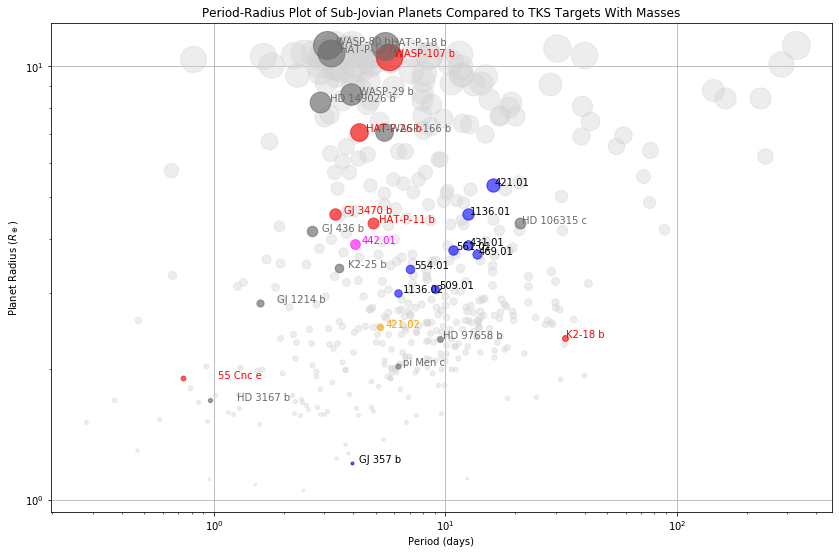

In [32]:
kpwks, hf = return_known_spectra()
#data_copy = b.copy()
b['has_spectrum'] = has_obs(b, kpwks)

rbin1=b[np.logical_or(
    np.logical_or.reduce((
        b[id_key] == 561.01, b[id_key] == 554.01, 
        b[id_key] == 421.01, b[id_key] == 469.01, 
        b[id_key] == 509.01, b[id_key] == 'GJ 357 b', 
        b[id_key] == 431.01, b[id_key] == 1136.01, 
        b[id_key] == 1136.02,b[id_key] == 431.01,
        b[id_key] == 442.01
        )), 
    b['has_spectrum']==1
    )
       ]

rbin2 = b[vtype(b[id_key])==str]
F2 = np.array(rbin2[Fp_key])
P2 = np.array(rbin2[pp_key])
#Ts = np.array(rbin1[Ts_key])
rp2 = np.array(rbin2[rp_key])
#P = np.array(rbin1['priority'])
N2 = np.array(rbin2[id_key])

#F = np.array(rbin1[Fp_key])
P = np.array(rbin1[pp_key])
#Ts = np.array(rbin1[Ts_key])
rp = np.array(rbin1[rp_key])
#P = np.array(rbin1['priority'])
N = np.array(rbin1[id_key])


def colorfinder(name, priority):
    if name in kpwks:
        idx = kpwks.index(name)
        if hf[idx]:
            return 'red'
        elif not hf[idx]:
            return 'dimgrey'
    else:
        if name != 442.01:
            return 'blue'
        elif name == 442.01:
            return 'magenta'
    
def textcolorfinder(name):
    if name in kpwks:
        idx = kpwks.index(name)
        if hf[idx]:
            return 'red'
        elif not hf[idx]:
            return 'dimgrey'
    else:
        if name != 442.01:
            return 'black'
        elif name == 442.01:
            return 'magenta'

fig, ax = plt.subplots(figsize=(14,9))
ax.grid()
txt = np.array(rbin1[id_key])
txt2= np.array(rbin2[id_key])

#doing the title stuff
#bin_edges = np.round(bins[0],1)
title_txt = r'Period-Radius Plot of Sub-Jovian Planets Compared to TKS Targets With Masses'


for i in np.arange(len(rbin2)):
    if 'EPIC' in txt2[i] or 'K0' in txt2[i]:
        continue
    ax.loglog(P2[i], rp2[i], '.',ms=rp2[i]*5,color='lightgrey',alpha=0.4)

for i in np.arange(len(rbin1)):
    ax.loglog(P[i], rp[i], '.',ms=rp[i]*5,color=colorfinder(N[i],P[i]),alpha=0.6)
    ax.annotate(txt[i], (P[i]+0.3, rp[i]),color=textcolorfinder(N[i]))


    #421.02
ax.plot(5.19588, 2.5, '.',ms=2.5*5,color='orange',alpha=0.6)
ax.annotate('421.02', (5.19588+0.3, 2.5),color='orange')

#try to plot the beak
#plt.plot((0,5),(1.7,4),'k--')

#height = 5700
    #earth dot size
#ax.semilogx(2e-1, height, '.', ms=5, color='black')
#ax.annotate(r'$1 R_\oplus$', (2e-1+1e-2, height-25),color=textcolorfinder(N[i]))
#
#    #neptune dot size
#ax.semilogx(2e-1, height+200, '.', ms=20, color='black')
#ax.annotate(r'$4 R_\oplus$', (2e-1+2e-2, height+200-25),color=textcolorfinder(N[i]))
#
#    #sligthly sub-Jovian dot size
#ax.semilogx(2e-1, height+500, '.', ms=50, color='black')
#ax.annotate(r'$10 R_\oplus$', (2e-1+4e-2, height+500-25),color=textcolorfinder(N[i]))
    
##added for TKS in person
#for f in np.arange(1,6,1):
#    for t in np.arange(1,4,1):
#        try:
#            size = len(b.loc[rbin,f,t])
#            ax.annotate('   ' + str(size),(fpl_bins[f-1],tef_bins[t-1]+1100))
#        except KeyError:
#            continue
#
#ax.set_yticks(tef_bins)
#ax.set_xlim([0,35])
#ax.set_xticks([0,5,10,15,20,25,30,35])
ax.set_ylabel('Planet Radius ($R_\oplus$)')
ax.set_xlabel(r'Period (days)')
ax.set_title(title_txt)

Text(0.5, 1.0, 'Planets from 1-11.2 $R_\\oplus$ with TKS Masses, Compared to Planets With Known Spectra')

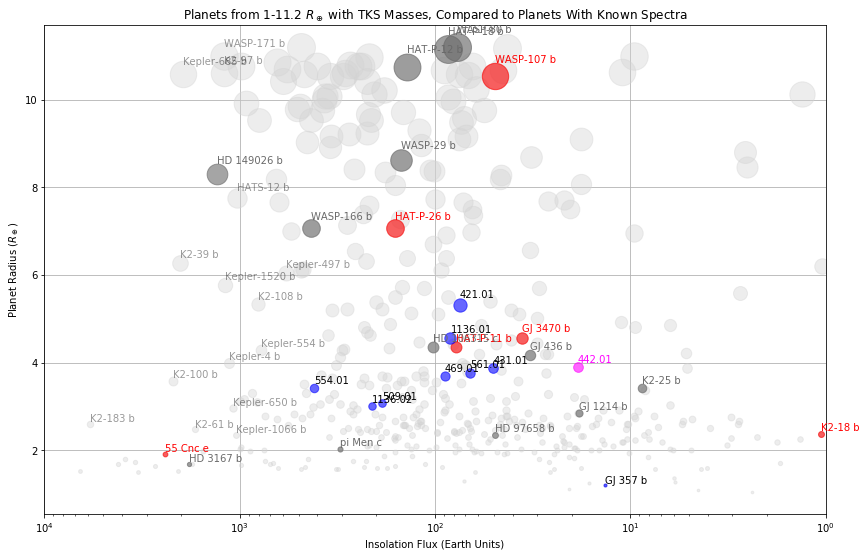

In [33]:
#TRYING TO DO IT WITH FP INSTEAD OF PERIOD BECAUSE 
#PERIOD BASICALLY HAS NO PHYSICAL INFORMATION

kpwks, hf = return_known_spectra()
#data_copy = b.copy()
b['has_spectrum'] = has_obs(b, kpwks)

rbin1=b[np.logical_or(
    np.logical_or.reduce((
        b[id_key] == 561.01, b[id_key] == 554.01, 
        b[id_key] == 421.01, b[id_key] == 469.01, 
        b[id_key] == 509.01, b[id_key] == 'GJ 357 b', 
        b[id_key] == 431.01, b[id_key] == 1136.01, 
        b[id_key] == 1136.02,b[id_key] == 431.01,
        b[id_key] == 442.01, b[id_key] == 'Kepler-10 b'
        )), 
    b['has_spectrum']==1
    )
       ]

#for the other known planets
rbin2 = b[vtype(b[id_key])==str]
F2 = np.array(rbin2[Fp_key])
P2 = np.array(rbin2[pp_key])
#Ts = np.array(rbin1[Ts_key])
rp2 = np.array(rbin2[rp_key])
#P = np.array(rbin1['priority'])
N2 = np.array(rbin2[id_key])

F = np.array(rbin1[Fp_key])
P = np.array(rbin1[pp_key])
#Ts = np.array(rbin1[Ts_key])
rp = np.array(rbin1[rp_key])
#P = np.array(rbin1['priority'])
N = np.array(rbin1[id_key])


def colorfinder(name, priority):
    if name in kpwks:
        idx = kpwks.index(name)
        if hf[idx]:
            return 'red'
        elif not hf[idx]:
            return 'dimgrey'
    else:
        if name != 442.01:
            return 'blue'
        elif name == 442.01 or name == 'K2-22 b':
            return 'magenta'
    
def textcolorfinder(name):
    if name in kpwks:
        idx = kpwks.index(name)
        if hf[idx]:
            return 'red'
        elif not hf[idx]:
            return 'dimgrey'
    else:
        if name != 442.01:
            return 'black'
        elif name == 442.01 or name == 'K2-22 b':
            return 'magenta'

fig, ax = plt.subplots(figsize=(14,9))
ax.grid()
txt = np.array(rbin1[id_key])
txt2 = np.array(rbin2[id_key])

#doing the title stuff
#bin_edges = np.round(bins[0],1)
title_txt = r'Planets from 1-11.2 $R_\oplus$ with TKS Masses, Compared to Planets With Known Spectra'


for i in np.arange(len(rbin2)):
    if 'EPIC' in txt2[i] or 'K0' in txt2[i]:
        continue
    if txt2[i] == 'HD 149026 b':
        continue
    ax.semilogx(F2[i], rp2[i], '.',ms=rp2[i]*5,color='lightgrey',alpha=0.4)
    if np.logical_or(np.logical_and(F2[i]>10**3, rp2[i]>2), 
                     np.logical_and.reduce((F2[i]>5e2,rp2[i]>4,rp2[i]<7))):
        ax.annotate(txt2[i], (F2[i], rp2[i]*(1+0.02)),color='black',alpha=0.4)

for i in np.arange(len(rbin1)):
    ax.semilogx(F[i], rp[i], '.',ms=rp[i]*5,color=colorfinder(N[i],P[i]),alpha=0.6)
    ax.annotate(txt[i], (F[i], rp[i]*(1+0.03)),color=textcolorfinder(N[i]))


    #421.02
#ax.plot(5.19588, 2.5, '.',ms=2.5*5,color='orange',alpha=0.6)
#ax.annotate('421.02', (5.19588+0.3, 2.5),color='orange')

#try to plot the beak
#plt.plot((0,5),(1.7,4),'k--')

#height = 5700
    #earth dot size
#ax.semilogx(2e-1, height, '.', ms=5, color='black')
#ax.annotate(r'$1 R_\oplus$', (2e-1+1e-2, height-25),color=textcolorfinder(N[i]))
#
#    #neptune dot size
#ax.semilogx(2e-1, height+200, '.', ms=20, color='black')
#ax.annotate(r'$4 R_\oplus$', (2e-1+2e-2, height+200-25),color=textcolorfinder(N[i]))
#
#    #sligthly sub-Jovian dot size
#ax.semilogx(2e-1, height+500, '.', ms=50, color='black')
#ax.annotate(r'$10 R_\oplus$', (2e-1+4e-2, height+500-25),color=textcolorfinder(N[i]))
    
##added for TKS in person
#for f in np.arange(1,6,1):
#    for t in np.arange(1,4,1):
#        try:
#            size = len(b.loc[rbin,f,t])
#            ax.annotate('   ' + str(size),(fpl_bins[f-1],tef_bins[t-1]+1100))
#        except KeyError:
#            continue
#
#ax.set_yticks(tef_bins)
#ax.set_xticks([0,5,10,15,20,25,30,35])
plt.xlim([10**4,10**0])
ax.set_ylabel('Planet Radius ($R_\oplus$)')
ax.set_xlabel(r'Insolation Flux (Earth Units)')
ax.set_title(title_txt)

In [34]:
b[b[id_key]=='K2-39 b']

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority,has_spectrum
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,5,2,NaN,NaN,K2-39 b,NaN,-9.022769,NaN,NaN,NaN,NaN,4.60543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.97,NaN,6.277,NaN,NaN,4881.0,NaN,2016.167343,NaN,NaN,NaN,NaN,0.66,28.6047,3.415866,14.528983,NaN,NaN,NaN,10.83,9.082,NaN,NaN,32.12531,106.0,4,5,2,1.0,0.0


In [35]:
b.loc[3,4,3]

Source Pipeline          TIC  \
radius_bin insol_bin st_Teff_bin                                
3          4         3                       NaN          NaN   
                     3                      spoc  453211454.0   
                     3                      spoc  407966340.0   
                     3                       qlp  322202434.0   
                     3                      spoc  142276270.0   
...                                          ...          ...   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   

                                        Full TOI ID  TIC Right Ascension  \
radius_bin insol_bin st_Teff_bin                                           
3          4         3            EPIC 212178066.01                  NaN   
                     3                       509.01           117.924970   
                     3                       554.01            60.747939   
                     3                      1617.01           325.324434   
                     3                      1136.02           192.184889   
...                                             ...                  ...   
                     3                 Kepler-565 b                  NaN   
                     3                Kepler-1065 b                  NaN   
                     3                 Kepler-464 b                  NaN   
                     3                     K2-256 b                  NaN   
                     3                 Kepler-608 b                  NaN   

                                  TIC Declination  TMag Value  \
radius_bin insol_bin st_Teff_bin                                
3          4         3                  23.685905         NaN   
                     3                   9.386054       7.905   
                     3                   9.208501       6.414   
                     3                  68.807077      10.251   
                     3                  64.855319       8.936   
...                                           ...         ...   
                     3                  47.196686         NaN   
                     3                  38.790501         NaN   
                     3                  48.982361         NaN   
                     3                  -2.065931         NaN   
                     3                  44.638096         NaN   

                                  TMag Uncertainty  Orbital Epoch Value  \
radius_bin insol_bin st_Teff_bin                                          
3          4         3                         NaN                  NaN   
                     3                       0.018          1494.445731   
                     3                       0.018          1442.619254   
                     3                       0.006          1739.326430   
                     3                       0.006          1688.716985   
...                                            ...                  ...   
                     3                         NaN                  NaN   
                     3                         NaN                  NaN   
                     3                         NaN                  NaN   
                     3                         NaN                  NaN   
                     3                         NaN                  NaN   

                                  Orbital Epoch Error  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                                              
3          4         3                            NaN             15.613426   
                     3                       0.001498              9.059905   
                     3                       0.001900       

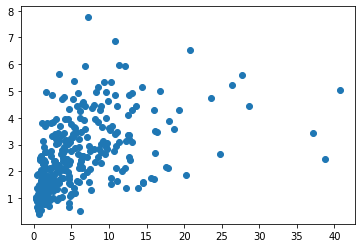

In [36]:
plt.scatter(b[pp_key], b['Transit Duration Value'])

In [141]:
b[b[id_key]=='GJ 436 b']

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority,has_spectrum
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,3,1,NaN,NaN,GJ 436 b,NaN,26.70657,NaN,NaN,NaN,NaN,2.643883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,NaN,4.17,NaN,NaN,3479.0,NaN,32.808004,NaN,NaN,NaN,NaN,0.47,22.1,13.603963,16.936752,NaN,NaN,NaN,10.67,6.9,NaN,NaN,495.798009,13.0,4,3,1,1.0,1.0


In [60]:
all_idx = binned.index.tolist()
unique_idx = []
for element in all_idx: 
    if element not in unique_idx:
        unique_idx.append(element)

Source Pipeline                                                                          spoc
TIC                                                                               2.44161e+08
Full TOI ID                                                                            278.01
TIC Right Ascension                                                                    4.8831
TIC Declination                                                                       -5.9113
TMag Value                                                                             13.099
TMag Uncertainty                                                                        0.059
Orbital Epoch Value                                                                   1386.11
Orbital Epoch Error                                                                  0.000835
Orbital Period Value                                                                 0.298746
Orbital Period Error                                        

In [61]:
b[b[id_key]==278.01]

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority,has_spectrum
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,1,spoc,244161191.0,278.01,4.8831,-5.9113,13.099,0.059,1386.106592,0.000835,0.298746,0.000023,1.046606,0.071629,12047.111814,716.01935,3,possible dipper; not a planet candidate; Rstar...,5.13527,0.496238,1.0,0.154,0.032,2.630575,2.642784,780.93174,2955.0,95.0,87.896848,13.262328,False,2018-12-11 21:32:33+0000,2018-12-11 21:32:33+0000,0.118016,7.434309,5.991786,29.609488,244161191.0,4.883562,-5.911561,16.45,11.171,10.618,10.324,647.597123,NaN,3,3,1,2.0,0.0
